In [1]:
!nvidia-smi

Tue Feb 14 04:29:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000001:00:00.0 Off |                  Off |
| N/A   28C    P0    29W / 250W |  15782MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# # ! apt-get update && apt-get install libgl1 -y 
!pip install visualkeras
!pip install tensorflow-addons==0.16.1
!pip install scikit-learn
!pip install plotly
!pip install opencv-python
! pip install pydot
! apt install graphviz -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 74 not upgraded.


In [ ]:
!apt-get install ffmpeg libsm6 libxext6  -y

In [6]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 12.7 MB/s eta 0:00:00


In [7]:

import os
import warnings
import itertools
import cv2
import seaborn as sns
import pandas as pd
import numpy  as np
from PIL import Image
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter

import tensorflow as tf

import tensorflow_addons as tfa
import visualkeras
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings('ignore')
%matplotlib inline

In [8]:
!ls input_dataset

non_tumorous  tumorous


In [9]:
# General parameters
epochs = 15
pic_size = 240
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
!pwd

/run/determined/workdir/Users/examples/BTD_CNN


In [ ]:
/run/determined/workdir/Users/examples/BTD_CNN/

In [42]:
folder_path = "input_dataset"
non_tumorous_dataset_list = os.listdir("input_dataset/non_tumorous/")
non_tumorous_dataset_path= "input_dataset/non_tumorous/"
tumorous_dataset_list = os.listdir("input_dataset/tumorous/")
tumorous_dataset_path = "input_dataset/tumorous/"


# for image_name in non_tumorous_dataset_list:
#     print(tumorous_dataset_path + image_name)
#     image=cv2.imread(non_tumorous_dataset_path + image_name)
#     image=Image.fromarray(image,'RGB')

def data_prep():
    non_tumorous_dataset_array=[]
    tumorous_dataset_array=[]
    for image_name in non_tumorous_dataset_list:
        try:
            print(non_tumorous_dataset_path+ image_name)
            image=cv2.imread(non_tumorous_dataset_path+ image_name)
            image=Image.fromarray(image,'RGB')
            image=image.resize((240,240))
            non_tumorous_dataset_array.append(np.array(image))
            tumorous_dataset_array.append(0)
        except AttributeError:
            print(non_tumorous_dataset_path+ image_name)
        
    for image_name in tumorous_dataset_list:
        try:
            image=cv2.imread(tumorous_dataset_path + image_name)
            image=Image.fromarray(image,'RGB')
            image=image.resize((240,240))
            non_tumorous_dataset_array.append(np.array(image))
            tumorous_dataset_array.append(1)
        except AttributeError:
            print(non_tumorous_dataset_path+ image_name)
    return non_tumorous_dataset_array,tumorous_dataset_array

In [43]:
!ls -lh "input_dataset/non_tumorous/4 no.jpg"

-rw-r--r-- 1 root root 6.3K Feb  2 08:12 'input_dataset/non_tumorous/4 no.jpg'


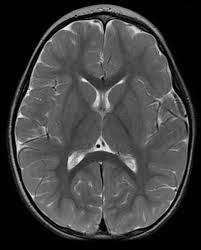

In [44]:
Image.fromarray(cv2.imread("input_dataset/non_tumorous/4 no.jpg"),'RGB')

In [ ]:
non_tumorous_dataset_array,tumorous_dataset_array =  data_prep()
non_tumorous_dataset_array = np.array(non_tumorous_dataset_array)
tumorous_dataset_array = np.array(tumorous_dataset_array)
#print(non_tumorous_dataset_array.shape, tumorous_dataset_array.shape)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(non_tumorous_dataset_array, tumorous_dataset_array, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
def plot_state(state):
    plt.figure(figsize= (12,12))
    for i in range(1, 13, 1):
        plt.subplot(3,4,i)
        img = load_img(folder_path + "/" + state + "/" + os.listdir(folder_path + "/" + state)[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

In [ ]:
plot_state('tumorous')

In [ ]:
plot_state('non_tumorous')

In [ ]:
model = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid",input_shape=(pic_size,pic_size,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2), activation="relu", padding="valid"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu', 
                          kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                          bias_regularizer=regularizers.L2(1e-2),
                          activity_regularizer=regularizers.L2(1e-3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid'),
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
visualkeras.layered_view(model, legend=True)

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

In [ ]:
model_trained = model.fit(x_train,y_train,epochs = 100, class_weight=class_weights, validation_data=(x_test, y_test),verbose=1)

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_trained.history['loss'], label='Training Loss')
plt.plot(model_trained.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(model_trained.history['accuracy'], label='Training Accuracy')
plt.plot(model_trained.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
results = model.evaluate(x_test, y_test)
print('The current model achieved an accuracy of {}%!'.format(round(results[1]*100,2)))

In [ ]:
# compute predictions
predictions = model.predict()
y_pred = []
for i in predictions:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [ ]:
predictions = model.predict(x_test[:1][:][:][:])
for i in predictions:
    if i >= 0.5:
        print(predictions, 1)
    else:
        print(predictions, 0)

In [ ]:
model.save("cnn_s_model")

In [ ]:
loda_model = tf.keras.models.load_model('cnn_s_model')

In [ ]:
input_non = "/run/determined/workdir/BTD_CNN/input_dataset/non_tumorous/17 no.jpg"

In [ ]:
input_image=cv2.imread(input_non)
input_image=Image.fromarray(input_image,'RGB')
input_image=input_image.resize((240,240))
input_image = np.array(input_image)
input_image = np.array([input_image])

input_image.shape


In [ ]:
loda_model.predict(input_image)

In [ ]:
x = []
y = []
for image_name in [input_non]:
    image=cv2.imread(image_name)
    image=Image.fromarray(image,'RGB')
    image=image.resize((240,240))
    x.append(np.array(image))
    y.append(0)
    
x =np.array(x)
x.shape

In [ ]:
x.shape

In [ ]:
x_test[:1][:][:][:].shape

In [ ]:
test_results['reloaded'] = reloaded.evaluate(test_features, test_labels, verbose=0)